In [1]:
import zipfile
import os
import rasterio
from rasterio import features
import numpy as np
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

300 to 700 in increments of 100 as threshold value

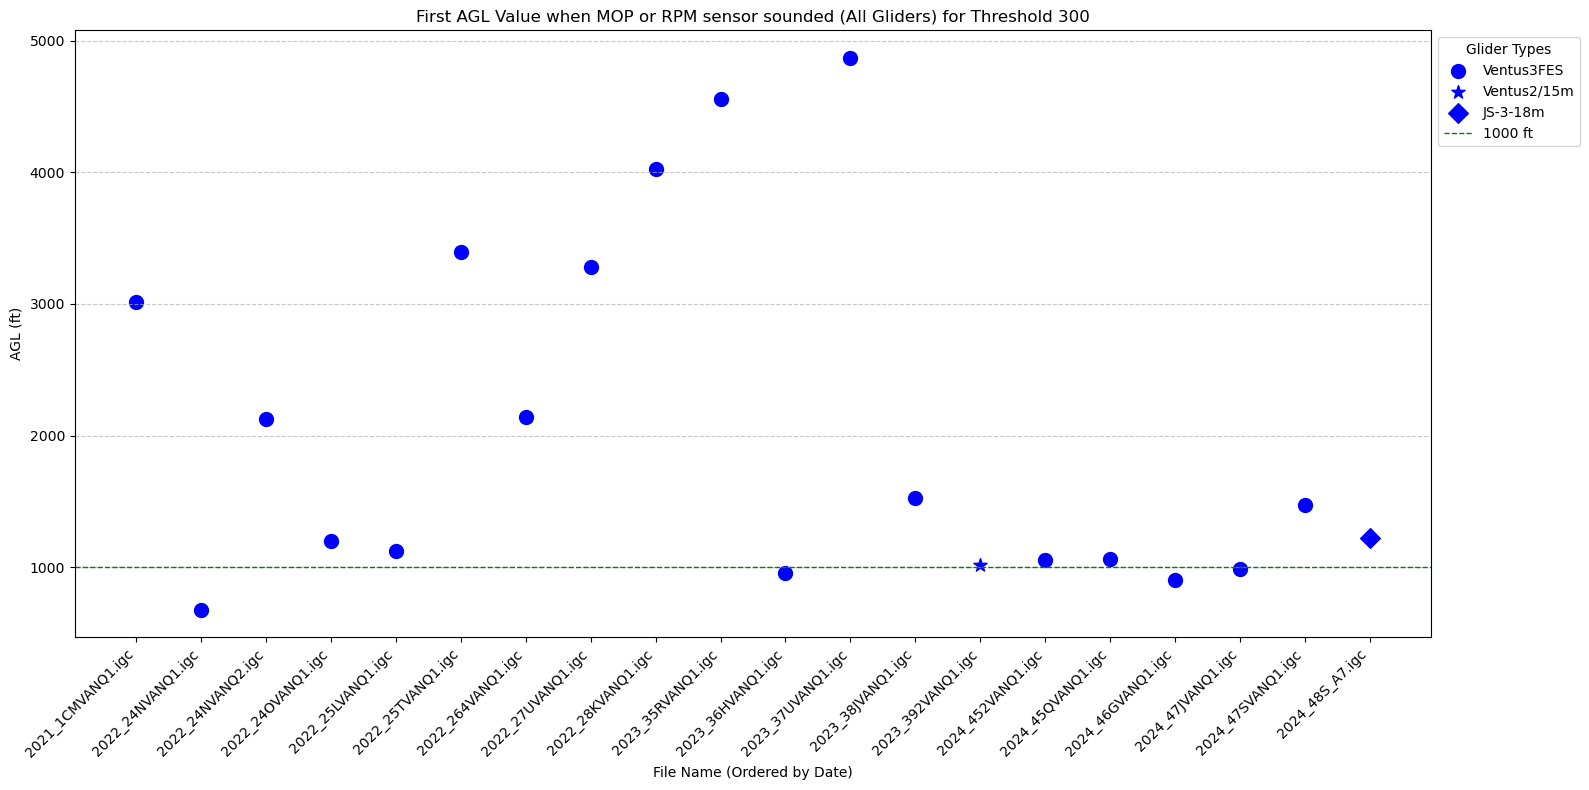

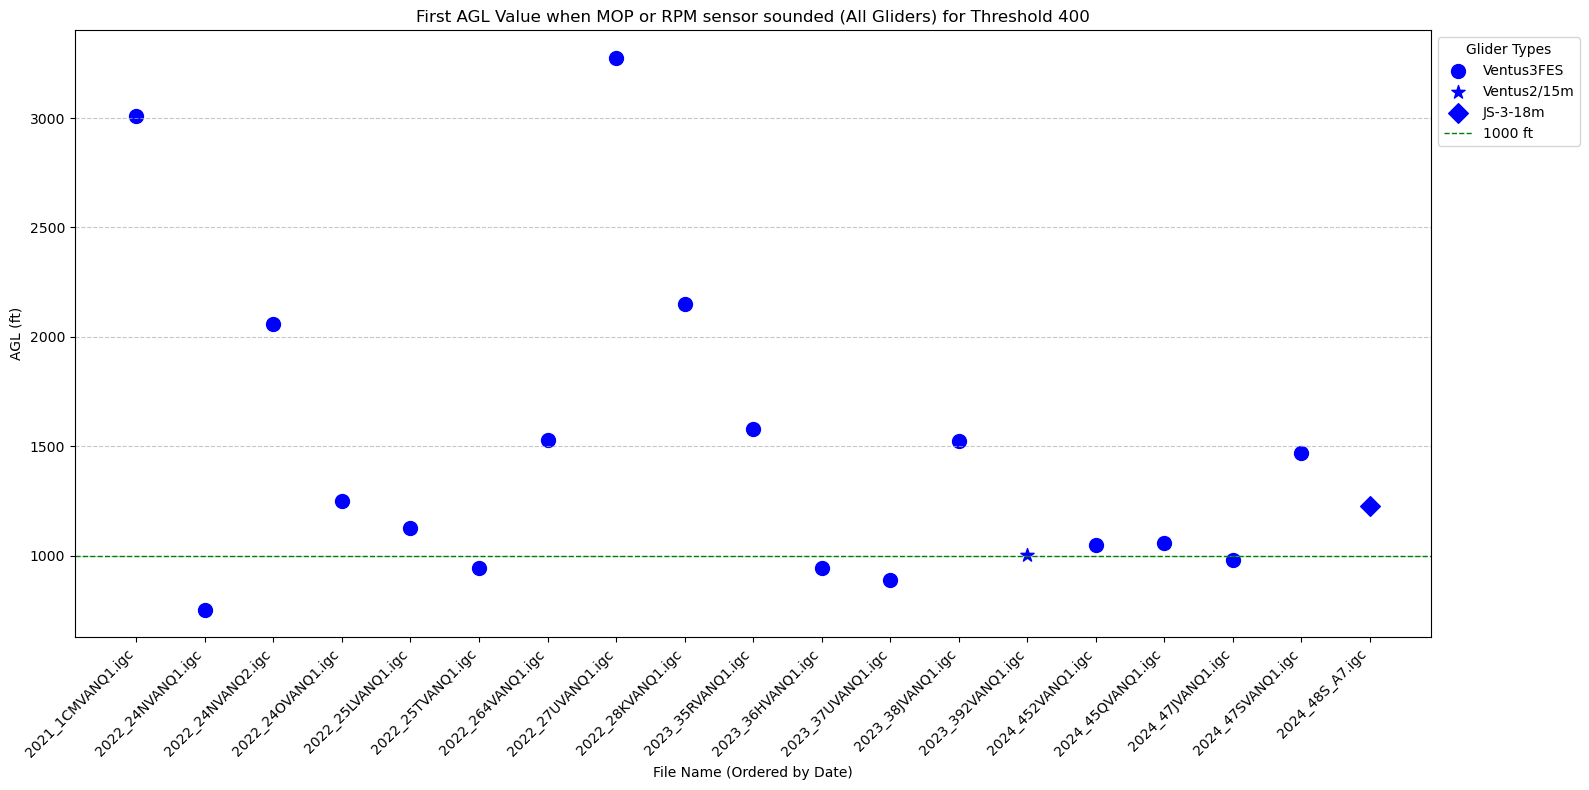

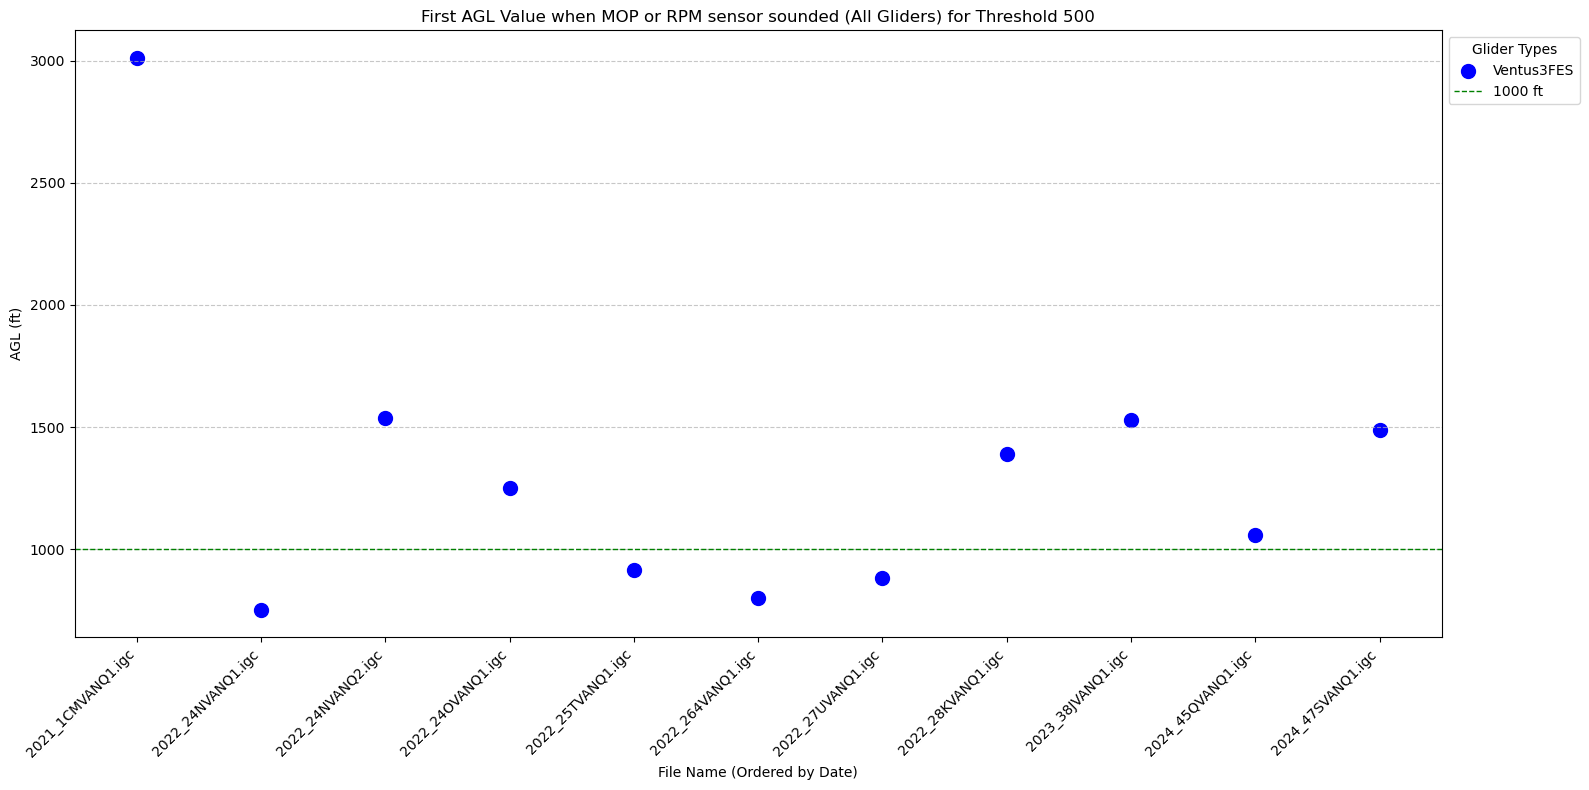

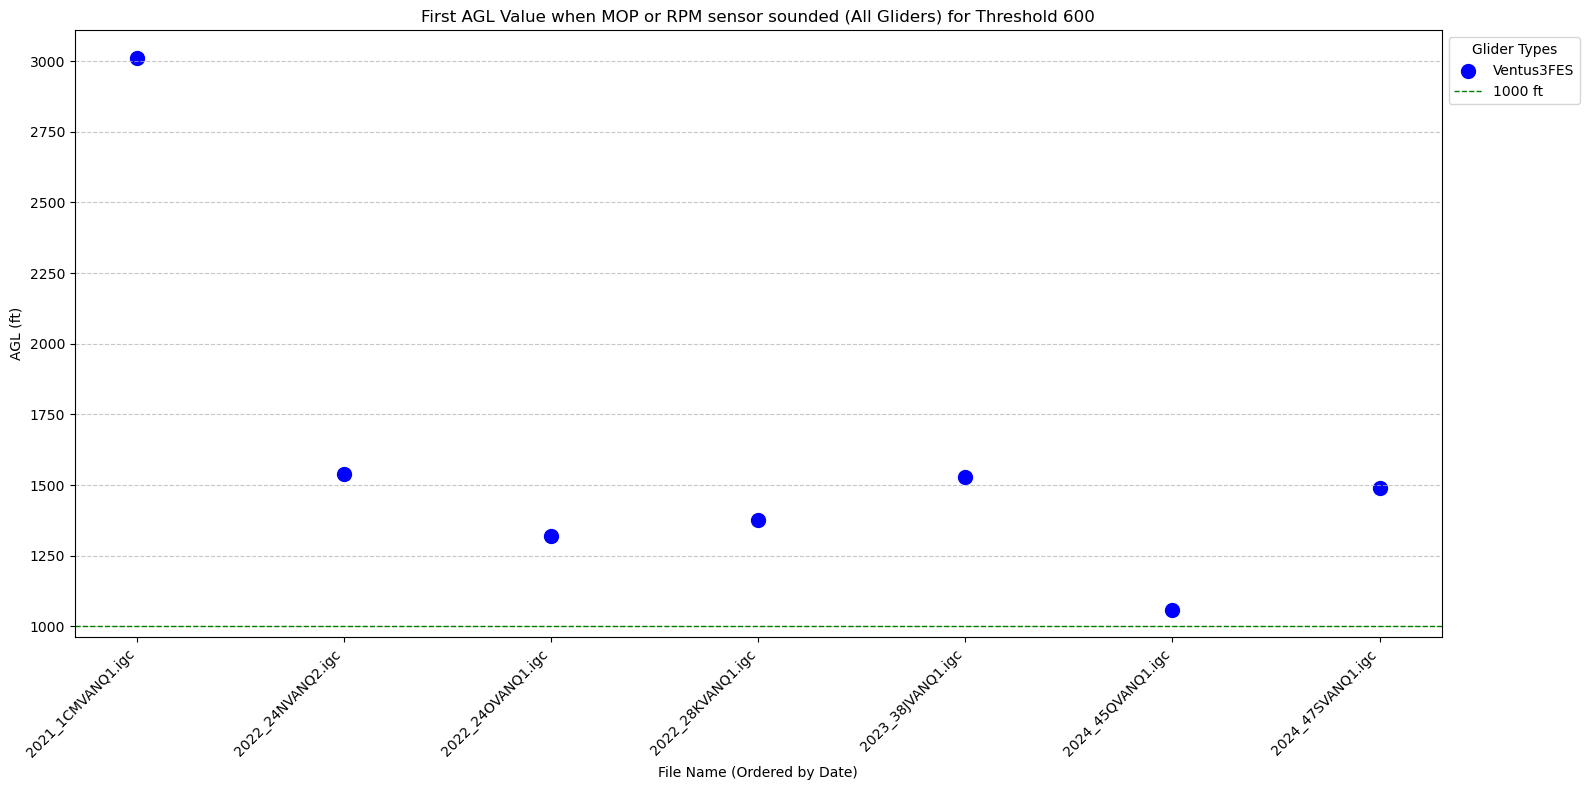

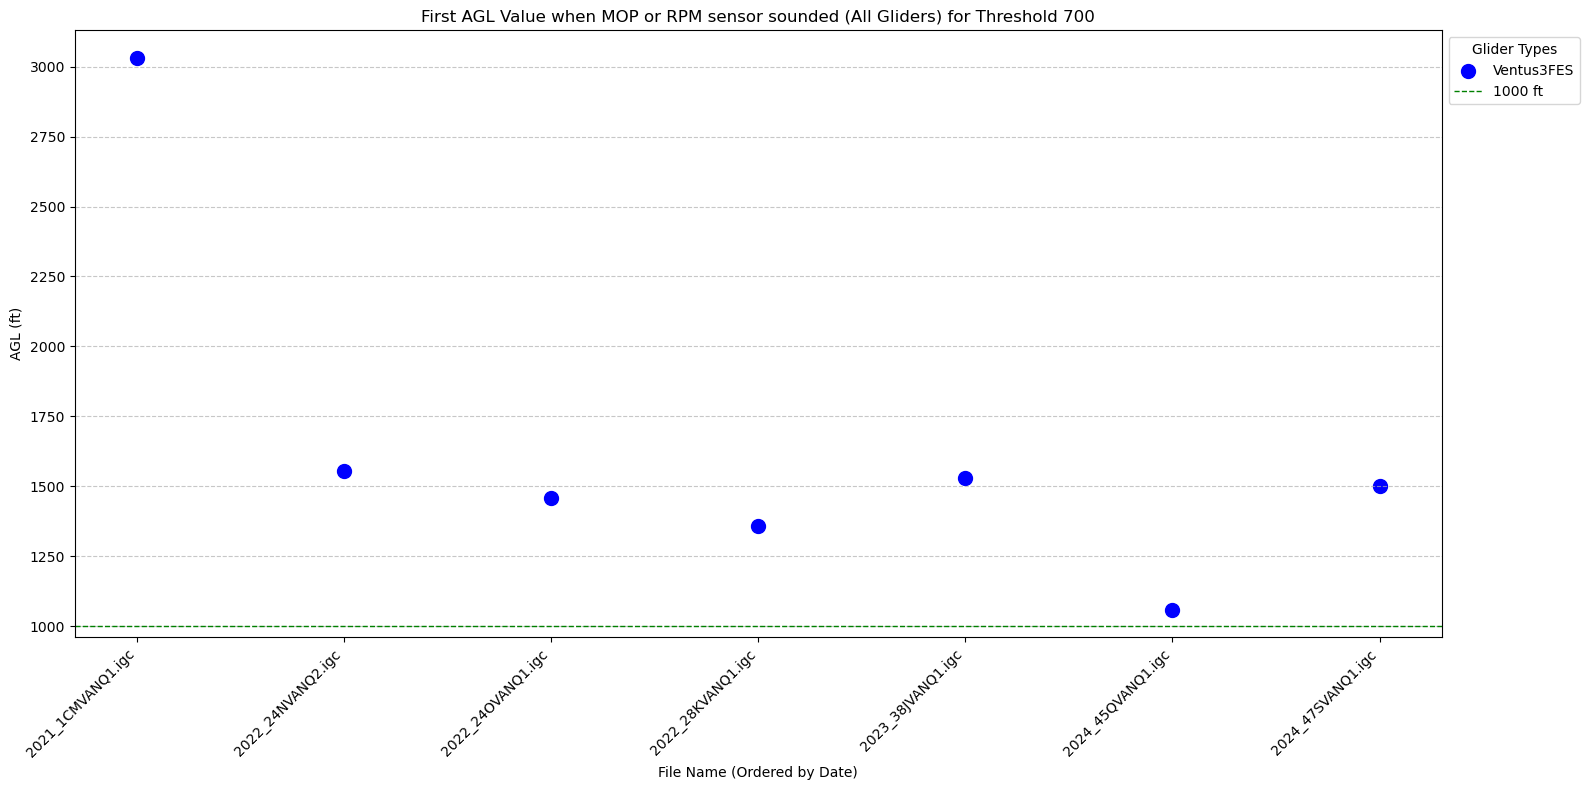

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

# Define thresholds
thresholds = [300, 400, 500, 600, 700]

# Define the years to process
years = ['2013', '2019', '2020', '2021', '2022', '2023', '2024']

# Construct file paths for all specified years
file_paths_by_year = {year: f'Flt-times_{year}.csv' for year in years}

# Define marker map for glider types
marker_map = {
    "Ventus3FES": "o",
    "ASK-21": "s",
    "JS-3-18m": "D",
    "ASH31/21m": "^",
    "ASW-27": "v",
    "Discus-2c": "P"
}

# Load all data once
data_by_year = {}
for year, file_path in file_paths_by_year.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        data_by_year[year] = df
    else:
        print(f"Warning: File {file_path} does not exist and will be skipped.")

# Process each threshold
for threshold in thresholds:
    sensor_info_col = f"Sensor Info ({threshold})"
    file_labels = []
    agl_all_first_values = []
    glider_types = []
    dates = []

    # Loop through each year and extract data from the threshold-specific column
    for year, df in data_by_year.items():
        if sensor_info_col not in df.columns:
            # If the column doesn't exist for some reason, skip this threshold for that year
            continue

        # Extract rows where Sensor Info (threshold) is not null
        for _, row in df.iterrows():
            info = row[sensor_info_col]
            glider_type = row['Gtype']
            date_str = row['Date (MM/DD/YYYY)']
            # Convert date
            date = pd.to_datetime(date_str, format='%m/%d/%Y', errors='coerce')
            if pd.isna(date):
                continue

            if pd.notna(info):
                # Extract MOP or RPM sensor values from this threshold column
                # We look for patterns like: "MOP sensor at t=[...] and [values]AGL"
                # or "RPM sensor at t=[...] and [values]AGL"
                # The threshold columns contain similar info strings as the original Sensor Info column.
                matches = re.findall(r'(MOP|RPM).*?\[([\d, ]+)\]AGL', info)
                if matches:
                    # Take the first occurrence
                    sensor, values = matches[0]
                    first_value_str = values.split(',')[0].strip()
                    if first_value_str.isdigit():
                        first_value = int(first_value_str)
                        agl_all_first_values.append(first_value)
                        file_labels.append(f"{year}_{row['File']}")
                        glider_types.append(glider_type)
                        dates.append(date)

    # Create a DataFrame for plotting
    data = pd.DataFrame({
        'Date': dates,
        'File Label': file_labels,
        'AGL': agl_all_first_values,
        'Glider Type': glider_types
    })

    if data.empty:
        print(f"No data found for threshold {threshold}.")
        continue

    # Sort data by date
    data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

    # Plotting
    plt.figure(figsize=(16, 8))

    # Create a set to keep track of glider types for the legend
    plotted_glider_types = set()

    for idx, row in data.iterrows():
        marker = marker_map.get(row['Glider Type'], "*")  # Default marker if type not in map

        # Plot each point with the same color (blue)
        plt.scatter(
            idx,
            row['AGL'],
            color='b',
            marker=marker,
            s=100,
            label=row['Glider Type'] if row['Glider Type'] not in plotted_glider_types else None
        )

        plotted_glider_types.add(row['Glider Type'])

    plt.axhline(y=1000, color='g', linestyle='--', linewidth=1, label='1000 ft')

    # Set x-ticks
    if len(data) > 0:
        step = max(1, len(data)//40)
        plt.xticks(
            ticks=range(0, len(data), step),
            labels=data['File Label'][::step],
            rotation=45,
            ha='right'
        )

    plt.xlabel('File Name (Ordered by Date)')
    plt.ylabel('AGL (ft)')
    plt.title(f'First AGL Value when MOP or RPM sensor sounded (All Gliders) for Threshold {threshold}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Glider Types", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
